In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.tree
import seaborn as sns
from scipy import stats

##添加隐藏代码的按钮
from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)

Toggle Code

In [37]:
data=pd.read_csv('E:\\pydata\\fanjin\\jd_result.csv')
jd_risk=pd.read_csv('E:\\pydata\\fanjin\\20190103_jd_riskBase.csv',encoding='gbk')

In [38]:
data.head()

,transport_id,DTI,loan_quality_gcnt,loan_quality_brate,gmv_min_val_cut,weight_time,AS_dispute_me,DSR_only_no_refund,gmv_last_6,gmv_last_mean_ratio,score,level,label
0,160598,0.095005,0,1,1,1.118904,0.00,False,2777778.20,0.798882,43,level_4,GOOD
1,160987,0.336425,1,0,0,1.200000,0.00,True,701202.06,1.330390,30,level_5,GOOD
2,161029,0.094538,3,0,0,0.936073,0.73,True,1163556.93,2.977863,68,level_3,GOOD
3,161055,0.083001,0,1,1,1.200000,0.05,True,6000000.00,0.163677,58,level_3,GOOD
4,161263,0.008332,2,0,0,1.002192,0.00,False,359249.50,1.026097,49,level_4,GOOD


In [39]:
jd_risk.head()

,transport_id,amt_decision_w,amt_loan_w,gmv12,max_active_days,month_decision,month_release,revolving_type_apply,flag_loan,dataloan_channel,lent_term,apr,MobDr1to3_od1,MobDr1to3_od30,MobDr1to4_od30,MobDr1to6_od10,MobDr1to6_od30,MobDr1to11_od30
0,95003,20.0,NaN,4.104291e+06,1187,2016-04,NaN,NaN,0,其他,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,39513,10.0,NaN,5.250712e+05,366,2015-12,NaN,NaN,0,其他,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,42598,4.0,4.0,3.777885e+05,588,2015-12,2015-12,NaN,1,其他,6.0,22.68,0.0,0.0,0.0,0.0,0.0,0.0
3,43376,15.0,NaN,1.872093e+05,590,2015-12,NaN,NaN,0,其他,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43577,10.0,10.0,2.497112e+05,771,2015-12,2016-01,NaN,1,其他,6.0,22.68,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
## merge 范进提供的数据及分享数据库中的京东逾期数据
dat_tot=pd.merge(data,jd_risk)
dat_tot.head()

,transport_id,DTI,loan_quality_gcnt,loan_quality_brate,gmv_min_val_cut,weight_time,AS_dispute_me,DSR_only_no_refund,gmv_last_6,gmv_last_mean_ratio,...,flag_loan,dataloan_channel,lent_term,apr,MobDr1to3_od1,MobDr1to3_od30,MobDr1to4_od30,MobDr1to6_od10,MobDr1to6_od30,MobDr1to11_od30
0,160598,0.095005,0,1,1,1.118904,0.00,False,2777778.20,0.798882,...,1,其他,12.0,27.60,0.0,0.0,0.0,0.0,0.0,0.0
1,160987,0.336425,1,0,0,1.200000,0.00,True,701202.06,1.330390,...,1,其他,6.0,26.28,0.0,0.0,0.0,0.0,0.0,0.0
2,161029,0.094538,3,0,0,0.936073,0.73,True,1163556.93,2.977863,...,1,其他,6.0,26.28,0.0,0.0,0.0,0.0,0.0,0.0
3,161055,0.083001,0,1,1,1.200000,0.05,True,6000000.00,0.163677,...,1,其他,12.0,27.60,0.0,0.0,0.0,0.0,0.0,0.0
4,161263,0.008332,2,0,0,1.002192,0.00,False,359249.50,1.026097,...,1,其他,12.0,31.68,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# 数据处理
dat=dat_tot
dat['num']=1
dat['revolving_type_apply']=dat['revolving_type_apply'].fillna(value='new')
#dat['flag_bad']=np.where(dat['label']=='GOOD',0,1)
dat['flag_bad']=dat['MobDr1to6_od30']

In [42]:
a=dat['flag_bad']
print('好坏样本个数：')
a.value_counts()

好坏样本个数：


0.0    505
1.0     31
Name: flag_bad, dtype: int64

## IV value

In [13]:
def woe_single(DF,Y,X):
    if X.nunique()>11:
        r = 0
        bad=Y.sum()      #坏客户数(假设因变量列为1的是坏客户)
        good=Y.count()-bad  #好客户数
        n=5
        while np.abs(r) < 1:
            d1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.qcut(X, n,duplicates='drop')})
            d2 = d1.groupby('Bucket', as_index = False)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        d3 = pd.DataFrame(d2.X.min(), columns = ['min'])
        d3['min']=d2.min().X    
        d3['max'] = d2.max().X
        d3['sum'] = d2.sum().Y
        d3['total'] = d2.count().Y
        d3['bad_rate'] = d2.mean().Y
        d3['group_rate']=d3['total']/(bad+good)
        d3['woe']=np.log((d3['bad_rate']/(1-d3['bad_rate']))/(bad/good))
        d3['iv']=(d3['sum']/bad-((d3['total']-d3['sum'])/good))*d3['woe']
        iv=d3['iv'].sum()
        if iv!=0.0 and len(d2)>1:
            d3['iv_sum']=iv
            woe=list(d3['woe'].round(6))
            cut=list(d3['min'].round(6))
            cut1=list(d3['max'].round(6))
            cut.append(cut1[-1]+1)
            x_woe=pd.cut(X,cut,right=False,labels=woe)
            return(iv,cut)
            #print(d3,'\ncut:\n',cut,'\nwoe:\n',woe,'\niv:\n',iv,'\nx_woe:\n',x_woe)
        else:
            dn1 = pd.DataFrame({"X": X, "Y": Y, "Bucket": pd.cut(X, 100)})
            dn2 = dn1.groupby('Bucket', as_index = False)
            dn3 = pd.DataFrame(dn2.X.min(), columns = ['min'])
            dn3['min']=dn2.min().X    
            dn3['max'] = dn2.max().X
            dn3['sum'] = dn2.sum().Y
            dn3['total'] = dn2.count().Y
            while (1):
                    if  (len(dn3)>4):
                        dn3_min_index = dn3[dn3.total == min(dn3.total)].index.values[0]
                        if (dn3_min_index!=0):    #最小值非第一行的情况
                            dn3.iloc[dn3_min_index-1, 1] =dn3.iloc[dn3_min_index, 1] 
                            dn3.iloc[dn3_min_index-1, 2] = dn3.iloc[dn3_min_index, 2] +dn3.iloc[dn3_min_index-1, 2]
                            dn3.iloc[dn3_min_index-1, 3] = dn3.iloc[dn3_min_index, 3] +dn3.iloc[dn3_min_index-1, 3]
                            dn3=dn3.drop([dn3_min_index])
                            dn3= dn3.reset_index(drop=True)
                        else:    #最小值是第一行的情况
                            dn3.iloc[dn3_min_index+1, 0] =dn3.iloc[dn3_min_index, 0] 
                            dn3.iloc[dn3_min_index+1, 2] = dn3.iloc[dn3_min_index, 2] +dn3.iloc[dn3_min_index+1, 2]
                            dn3.iloc[dn3_min_index+1, 3] = dn3.iloc[dn3_min_index, 3] +dn3.iloc[dn3_min_index+1, 3]
                            dn3=dn3.drop([dn3_min_index])
                            dn3= dn3.reset_index(drop=True)
                    else:
                        break
            dn3['bad_rate'] =dn3['sum']/dn3['total']
            dn3['group_rate']=dn3['total']/(bad+good)
            dn3['woe']=np.log((dn3['bad_rate']/(1-dn3['bad_rate']))/(bad/good))
            dn3['iv']=(dn3['sum']/bad-((dn3['total']-dn3['sum'])/good))*dn3['woe']
            
            iv=dn3['iv'].sum()
            dn3['iv_sum']=iv
            woe=list(dn3['woe'].round(6)) 
            cut=list(dn3['min'].round(6))
            cut1=list(dn3['max'].round(6))
            cut.append(cut1[-1]+1)
            x_woe=pd.cut(X,cut,right=False,labels=woe)
            return(iv,cut)
            #print(dn3,'\ncut\n',cut,'\nwoe\n',woe,'\niv\n',iv,'\nx_woe\n',x_woe)
    else : 
        bad=Y.sum()      #坏客户数
        good=Y.count()-bad  #好客户数
        d1 = pd.DataFrame({"X": X, "Y": Y})
        d2 = d1.groupby('X', as_index =True)
        d3 = pd.DataFrame()
        
        d3['sum'] = d2.sum().Y
        d3['total'] = d2.count().Y
        for c in range(d3.shape[0])[::-1]:
            if ((d3.iloc[c,1]-d3.iloc[c,0])==0) or (d3.iloc[c,0]==0):
                d3.iloc[c-1,0]=d3.iloc[c-1,0]+d3.iloc[c,0]
                d3.iloc[c-1,1]=d3.iloc[c-1,1]+d3.iloc[c,1]
                d3.drop(d3.index[c],inplace=True)
            else:
                continue
        
        d3['min']=d3.index  
        d3['max'] = d3.index
        d3['bad_rate'] =d3['sum']/d3['total']
        d3['group_rate']=d3['total']/(bad+good)
        d3['woe']=np.log((d3['bad_rate']/(1-d3['bad_rate']))/(bad/good))
        d3['iv']=(d3['sum']/bad-((d3['total']-d3['sum'])/good))*d3['woe']
        iv=d3['iv'].sum()
        d3['iv_sum']=iv
        d3=d3[['min','max','sum','total','bad_rate','group_rate','woe','iv','iv_sum']]
        
        
        woe=list(d3['woe'].round(6))
        cut=list(d3.index)
        x_woe=X.replace(cut,woe)
        return(iv,cut)
        #print(d3,'cut:\n',cut,'woe:\n',woe,'iv:\n',iv,'x_woe:\n',x_woe)

In [14]:
dat.columns

Index(['transport_id', 'DTI', 'loan_quality_gcnt', 'loan_quality_brate',
       'gmv_min_val_cut', 'weight_time', 'AS_dispute_me', 'DSR_only_no_refund',
       'gmv_last_6', 'gmv_last_mean_ratio', 'score', 'level', 'label',
       'amt_decision_w', 'amt_loan_w', 'gmv12', 'max_active_days',
       'month_decision', 'month_release', 'revolving_type_apply', 'flag_loan',
       'dataloan_channel', 'lent_term', 'apr', 'MobDr1to3_od1',
       'MobDr1to3_od30', 'MobDr1to4_od30', 'MobDr1to6_od10', 'MobDr1to6_od30',
       'MobDr1to11_od30', 'num', 'flag_bad'],
      dtype='object')

In [15]:
woe_single(dat,dat['flag_bad'],dat['AS_dispute_me'])

(0.06990210876491591, [0.0, 0.16, 0.32, 0.67, 16.740000000000002])

In [16]:
col_list=['DTI', 'loan_quality_gcnt', 'loan_quality_brate','gmv_min_val_cut', 'weight_time','AS_dispute_me',
       'DSR_only_no_refund','gmv_last_6', 'gmv_last_mean_ratio', 'score', 'level', 'label',
         'gmv12','max_active_days','revolving_type_apply']
#woe_single(dat,dat['flag_bad'],dat['AS_dispute_me'])

name=[]
iv=[]
cut=[]
count=[]
for i in col_list:
    name.append(i)
    iv.append(woe_single(dat,dat['flag_bad'],dat[i])[0])
    cut.append(woe_single(dat,dat['flag_bad'],dat[i])[1])
    count.append(len(woe_single(dat,dat['flag_bad'],dat[i])[1]))
iv_summary=pd.DataFrame({'name':name,'iv':iv,'cut':cut,'cnt':count})
iv_summary=iv_summary[['iv','name','cut','cnt']]
iv_summary.sort_values('iv',ascending=False)

,iv,name,cut,cnt
10,0.632954,level,"[level_1, level_3, level_4, level_5, level_6, ...",6
9,0.582907,score,"[4, 24, 49, 73, 100]",5
6,0.258073,DSR_only_no_refund,"[False, True]",2
3,0.257504,gmv_min_val_cut,"[0, 1]",2
14,0.191427,revolving_type_apply,"[REVOLVING, SUIJIE, new]",3
4,0.186143,weight_time,"[0.536986, 1.022356, 1.067671, 2.2]",4
13,0.166173,max_active_days,"[-1, 406, 419, 778, 3556]",5
12,0.101900,gmv12,"[0.0, 169194.1733, 345570.0483, 531503.555, 16...",5
0,0.082631,DTI,"[0.0, 0.094538, 0.249536, 0.399704, 2.182696]",5
1,0.073188,loan_quality_gcnt,"[0, 1, 2, 3]",4


## 单变量分析

In [17]:
# 等频分箱
def cut_go(dat,string,n):
    cutBox=dat
    cutBox=cutBox.sort_values(string)
    cutBox=cutBox.set_index(np.arange(1,len(cutBox[string])+1,1))
    
    sid=list(np.arange(1,len(cutBox[string])+1,(len(cutBox[string]))/n))
    sid[0]=-1
    sid.append(len(cutBox[string])+1)
    cutBox['cut']=pd.cut(cutBox.index,sid)
    
    return cutBox

In [18]:
# 等分画图
def go_pic(dat,obj,n):
    cut_obj=obj #替换字段#

    dat1=dat[[cut_obj,'flag_bad']]

    dat2=cut_go(dat1,cut_obj,n)
    dat2['num']=1
    dat2=dat2.sort_values(cut_obj)

    dat3=dat2.groupby('cut',as_index=False).agg({'flag_bad':sum,cut_obj:max,'num':sum})
    dat3['bad_rate']=dat3['flag_bad']/dat3['num']
    dat3=dat3.sort_values(cut_obj)

    cut_max=[]
    for i in np.arange(len(dat3[cut_obj])):
        cut_max.append(str(i)+'~~<='+str(round(dat3[cut_obj][i],2)))

    dat3['cut_max']=cut_max


    ## 可视化展示
    dat_plot=dat3

    dat_plot['X']=dat_plot['cut_max']
    dat_plot['Y']=dat_plot['bad_rate']
    dat_plot['Y2']=dat_plot['num']

    fig=plt.figure(figsize=(12,5))
    ax1=fig.add_subplot(1,1,1)
    ax1.bar(dat_plot['X'],dat_plot['Y2'],color='skyblue')
    #ax1.bar(dat_plot.X,dat_plot.Y3,color='b',bottom=dat_plot.Y)
    #ax1.set_ylim(0,30)
    ax1.set_ylabel('cnt',size=15)
    plt.xticks(rotation=45)

    ax2=ax1.twinx()
    ax2.plot(dat_plot['X'],dat_plot['Y'],'-',color='r')
    #ax2.set_ylim(0,1)
    ax2.set_ylabel(u'$rate$',size=15)
    plt.xticks(rotation=45)
    
    plt.title(cut_obj,size=20)

In [19]:
dat.dtypes

transport_id              int64
DTI                     float64
loan_quality_gcnt         int64
loan_quality_brate        int64
gmv_min_val_cut           int64
weight_time             float64
AS_dispute_me           float64
DSR_only_no_refund         bool
gmv_last_6              float64
gmv_last_mean_ratio     float64
score                     int64
level                    object
label                    object
amt_decision_w          float64
amt_loan_w              float64
gmv12                   float64
max_active_days           int64
month_decision           object
month_release            object
revolving_type_apply     object
flag_loan                 int64
dataloan_channel         object
lent_term               float64
apr                     float64
MobDr1to3_od1           float64
MobDr1to3_od30          float64
MobDr1to4_od30          float64
MobDr1to6_od10          float64
MobDr1to6_od30          float64
MobDr1to11_od30         float64
num                       int64
flag_bad

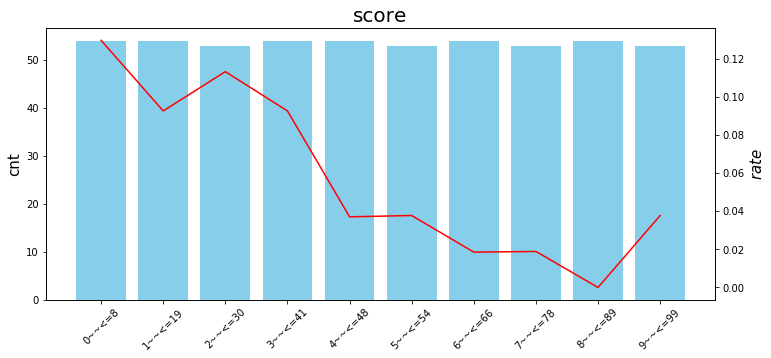

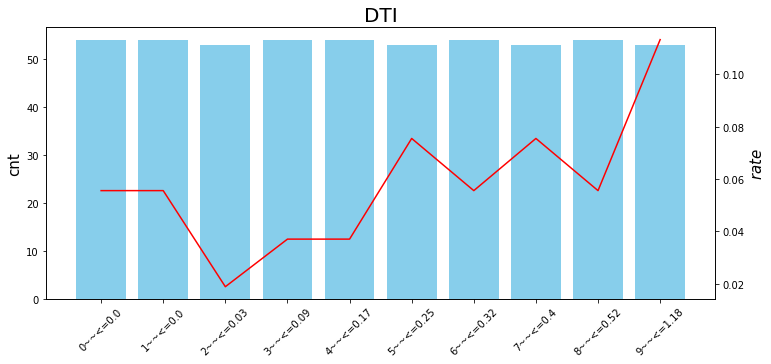

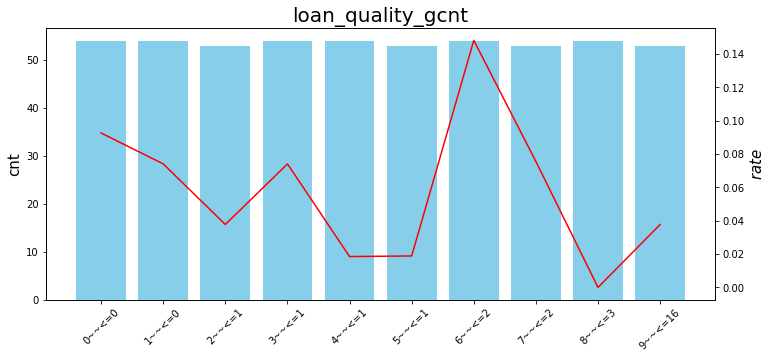

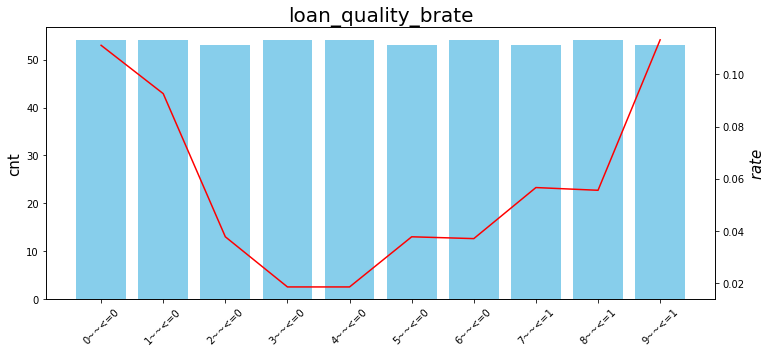

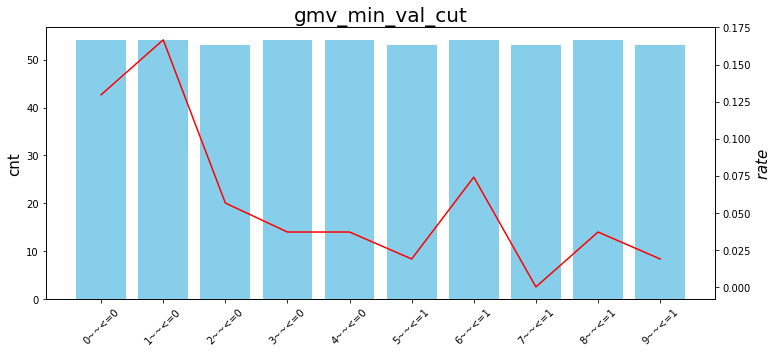

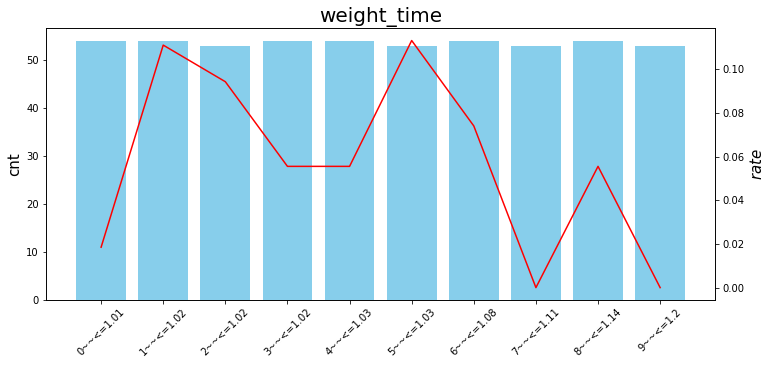

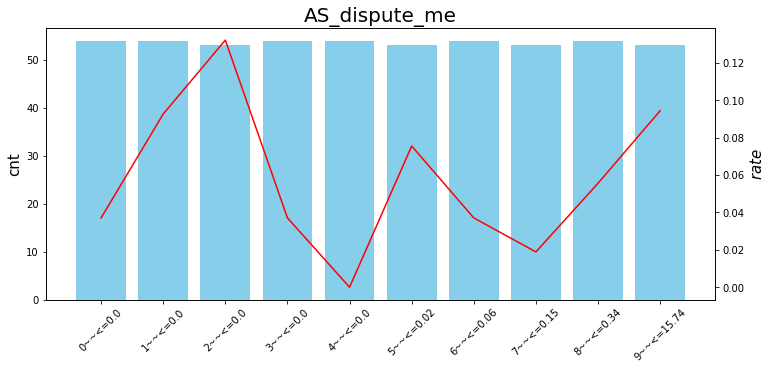

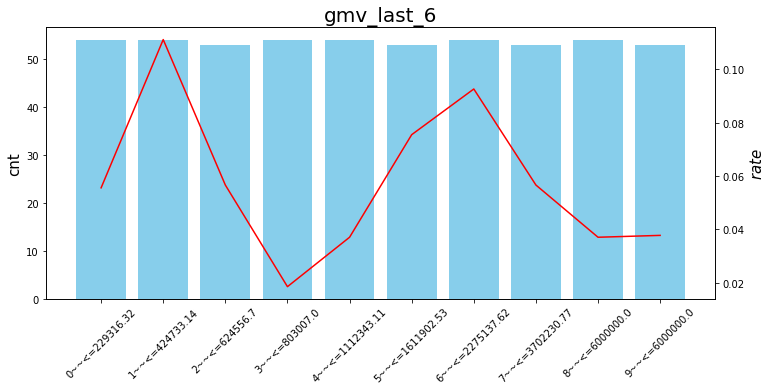

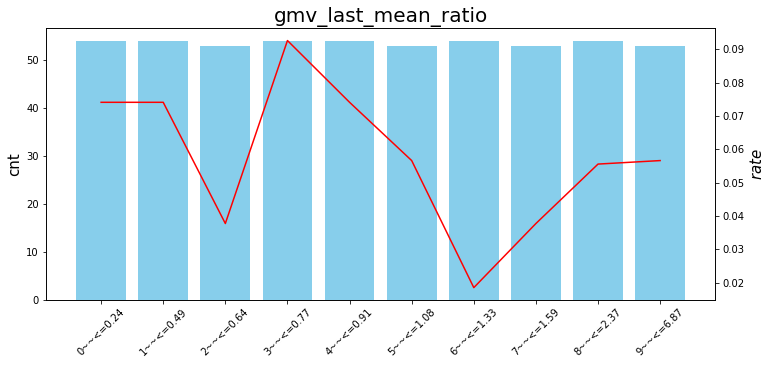

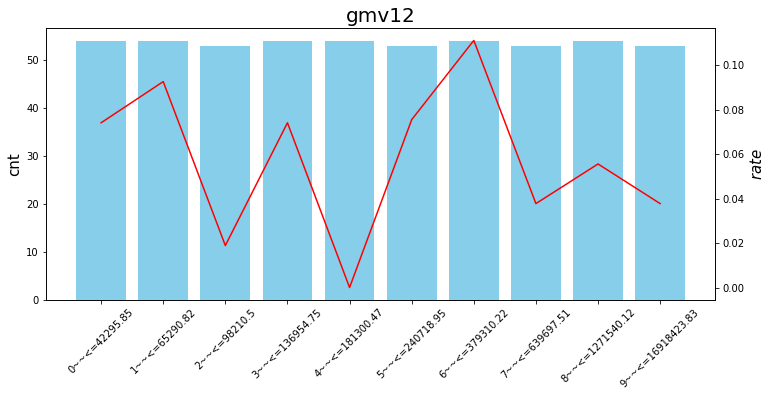

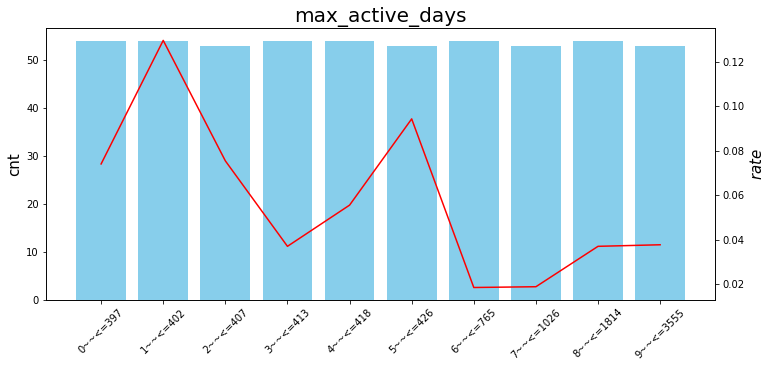

In [20]:
for i in ['score','DTI','loan_quality_gcnt','loan_quality_brate','gmv_min_val_cut','weight_time',
          'AS_dispute_me','gmv_last_6','gmv_last_mean_ratio',
         'gmv12','max_active_days']:
    go_pic(dat,i,10)

## 交叉验证

In [44]:
from sklearn import model_selection
from sklearn import metrics

x=dat
y=dat['flag_bad']
#将数据集分成训练集和测试集
X_train,X_test,Y_train,Y_test=model_selection.train_test_split(x,y,test_size=0.5,random_state=8)
print('shape_X_train:',X_train.shape)
print('shape_Y_train:',Y_train.shape)
print('shape_X_test:',X_test.shape)
print('shape_Y_test:',Y_test.shape)

shape_X_train: (268, 32)
shape_Y_train: (268,)
shape_X_test: (268, 32)
shape_Y_test: (268,)


In [107]:
## 寻找最佳切点
def bestP_go(dat):
    F1_List=[]
    i_List=[]
    for i in list(np.arange(min(dat['score']),max(dat['score']))):        
        dat['pre']=dat['score'].apply(lambda x:1 if x<=i else 0)
        mat=pd.DataFrame(pd.pivot_table(dat,values='num',index='pre',columns='flag_bad',aggfunc='sum'))

        tp=mat.loc[1,1]
        fp=mat.loc[1,0]
        tn=mat.loc[0,0]
        fn=mat.loc[0,1]

        accracny=(tp+tn)/(tp+tn+fp+fn)
        precision=tp/(tp+fp)
        recall=tp/(tp+fn)
        f1_score=2*precision*recall/(precision+recall)
    
        i_List.append(i)
        F1_List.append(f1_score)
        
        df=pd.DataFrame({'id':i_List,'f1_score':F1_List})
        df=df.dropna()
    return df[df['f1_score']==max(df['f1_score'])]  
        
bestP_go(X_train)

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,f1_score,id
35,0.216667,39


In [106]:
## 评价模型
X_train['pre']=X_train['score'].apply(lambda x:1 if x<39 else 0)
mat=pd.DataFrame(pd.pivot_table(X_train,values='num',index='pre',columns='flag_bad',aggfunc='sum'))

tp=mat.loc[1,1]
fp=mat.loc[1,0]
tn=mat.loc[0,0]
fn=mat.loc[0,1]

accracny=(tp+tn)/(tp+tn+fp+fn)
precision=tp/(tp+fp)
recall=tp/(tp+fn)
f1_score=2*precision*recall/(precision+recall)

print('混肴矩阵：\n',mat,'\n')
print('精确率 accracny：\n',accracny,'\n')
print('准确率 precision：\n',precision,'\n')
print('召回率 recall：\n',recall,'\n')
print('F1-score：\n',f1_score,'\n')

混肴矩阵：
 flag_bad  0.0  1.0
pre               
0         164    7
1          85   12 

精确率 accracny：
 0.6567164179104478 

准确率 precision：
 0.12371134020618557 

召回率 recall：
 0.631578947368421 

F1-score：
 0.20689655172413793 



F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## AUC及ROC曲线

Text(0.5,1,'Full Data')

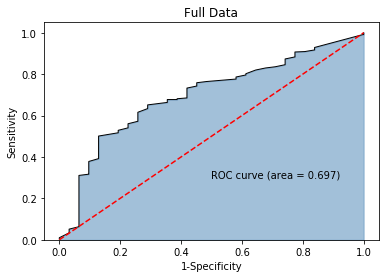

In [63]:
##  画ROC曲线
dat['pre']=dat['score'].apply(lambda x:1 if x<9 else 0)

fpr,tpr,threshold = metrics.roc_curve(1-dat['flag_bad'],dat['score']/100)

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.3f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Full Data')
# 显示图形

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Train Data')

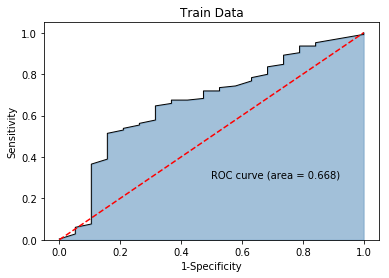

In [64]:
X_train['pre']=X_train['score'].apply(lambda x:1 if x<9 else 0)

fpr,tpr,threshold = metrics.roc_curve(1-X_train['flag_bad'],X_train['score'])

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.3f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Train Data')
# 显示图形

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0.5,1,'Test Data')

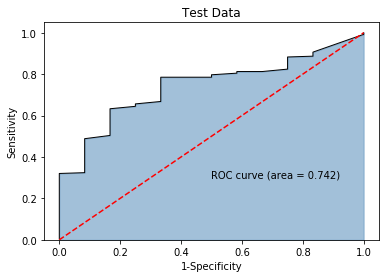

In [66]:
X_test['pre']=X_test['score'].apply(lambda x:1 if x<9 else 0)

fpr,tpr,threshold = metrics.roc_curve(1-X_test['flag_bad'],X_test['score'])

# 计算AUC的值
roc_auc = metrics.auc(fpr,tpr)
# 绘制面积图
plt.stackplot(fpr, tpr, color='steelblue', alpha = 0.5, edgecolor = 'black')
# 添加边际线
plt.plot(fpr, tpr, color='black', lw = 1)
# 添加对角线
plt.plot([0,1],[0,1], color = 'red', linestyle = '--')
# 添加文本信息
plt.text(0.5,0.3,'ROC curve (area = %0.3f)' % roc_auc)
# 添加x轴与y轴标签
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('Test Data')
# 显示图形